In [1]:
using DrWatson

@quickactivate "GRNEvoContingency"

projectname()

"GRNEvoContingency"

In [2]:
include(srcdir("TissueModel_ND.jl"))

include(srcdir("Evolution.jl"))
include(srcdir("FitnessFunctions.jl"))

include(srcdir("NetworkTopologies.jl"))
include(srcdir("Utility.jl"))

using Plots
using Random
using Parameters
using Printf
using DataFrames
using StatsPlots
using Distances
using LinearAlgebra
using MultivariateStats

using Base.Threads
using Base.Threads: @spawn

example_networks = load(datadir("exp_pro/80-40-80_networks/examples.jld"))
df = collect_results(datadir("sims/repeated_evolution_different_topologies"));

┌ Info: Scanning folder /Users/boothh/Documents/GRNEvoContingency/data/sims/repeated_evolution_different_topologies for result files.
└ @ DrWatson /Users/boothh/.julia/packages/DrWatson/UkasH/src/result_collection.jl:115
┌ Info: Added 8 entries.
└ @ DrWatson /Users/boothh/.julia/packages/DrWatson/UkasH/src/result_collection.jl:191


In [3]:
headings = ["topology",
            "target",
            "n_traj",
            "max_gen",
            "β",
            "noise_cv",
            "mutation_method",
            "noise_method",
            "n_max_iters_reached",
            "describe_proportion_mutants_rejected"];

df_current = filter(:n_traj=>x->x==2500,df);

In [4]:
evolutionary_runs = Dict{String,Any}("classical"=>df_current[:,"raw_data"][1],"feed_forward"=>df_current[:,"raw_data"][2],"mutual_inh"=>df_current[:,"raw_data"][3],"overlap_dom"=>df_current[:,"raw_data"][4]);

In [5]:
topology = "overlap_dom"
start_network = example_networks[topology]
run_data = evolutionary_runs[topology];

origin = vec(start_network);

In [6]:
w_path = map(x->x[2].traversed_topologies,run_data);

In [211]:
w1 = w_path[1]
# w_m = reduce(hcat,[vec(w) .- origin for w in w1])

# w_m = reduce(hcat,[vec(w1[i+1]) .- vec(w1[i])  for i in 1:length(w1)-1])

w_m = reduce(hcat,[vec(w) for w in w1])

12×293 Matrix{Float64}:
  0.0          0.0          0.0         …   0.0          0.0
  0.653415     0.653415     0.653415        0.206837     0.206837
 -0.424533    -0.424533    -0.424533       -0.12697     -0.12697
  0.0          0.0          0.0            -0.00632506  -0.00632506
  0.0          0.0          0.0             0.0          0.0
  0.150029     0.150029     0.150029    …   0.152314     0.152314
 -0.00379469  -0.00379469  -0.00379469     -0.0081784    0.00425806
  0.0          0.0          0.0            -0.0276024   -0.0276024
  0.0          0.0          0.0             0.0          0.0
  0.228214     0.228214     0.228214        0.188949     0.188949
  0.0          0.0          0.0         …   0.0          0.0
  0.0          0.0          0.0             0.0          0.0

In [212]:
M = fit(PCA, w_m; pratio=1, maxoutdim=2)

PCA(indim = 12, outdim = 2, principalratio = 0.9775674442565896)

Pattern matrix (unstandardized loadings):
──────────────────────────────
             PC1           PC2
──────────────────────────────
1    0.0           0.0
2    0.0629349     0.0212564
3   -0.052465      0.029068
4    7.89113e-5    7.50547e-5
5    0.0           0.0
6   -0.000529806   0.000179475
7    0.000439545  -9.47323e-6
8    0.00820028    0.00746715
9    0.0           4.23808e-18
10   0.0123332     0.0102283
11   0.0           0.0
12   0.0           0.0
──────────────────────────────

Importance of components:
────────────────────────────────────────────────
                                  PC1        PC2
────────────────────────────────────────────────
SS Loadings (Eigenvalues)  0.00693322  0.0014572
Variance explained         0.807789    0.169778
Cumulative variance        0.807789    0.977567
Proportion explained       0.826326    0.173674
Cumulative proportion      0.826326    1.0
────────────────────────────

In [213]:
# function get_first_pca(path)

#     w_m = reduce(hcat,[vec(w) for w in path])

#     M = fit(PCA, w_m; pratio=1, maxoutdim=2)
    
#     return projection(M)[:,1]
# end

# pca_path = map(x->get_first_pca(x),w_path)

# pca_path_m = reduce(hcat,pca_path)
# plot(pca_path_m[9,:])

# all_w_path = map(x->reduce(hcat,[vec(w) for w in x]),w_path)

In [214]:
pc1 = projection(M)[:,1]
pc2 = projection(M)[:,2]

12-element Vector{Float64}:
  0.0
 -0.5568389297764532
 -0.7614762387933499
 -0.0019661592020729307
  0.0
 -0.004701579873066297
  0.00024816419991033307
 -0.19561197457745014
 -1.1102230246251565e-16
 -0.26794452265287544
  0.0
  0.0

In [215]:
norm_pc1  = pc1 * (norm(origin)/norm(pc1))
norm_pc2  = pc1 * (norm(origin)/norm(pc2))

# norm_pc1  = pc1 * (1/norm(pc1))
# norm_pc2  = pc1 * (1/norm(pc2))

12-element Vector{Float64}:
  0.0
 -0.6240908201669652
  0.5202664694140391
 -0.000782519297787512
  0.0
  0.005253792874225198
 -0.004358720444459286
 -0.08131758262897655
  0.0
 -0.12230159038869197
  0.0
  0.0

In [216]:
grn_parameters = DefaultGRNParameters()

p = (start_network,grn_parameters.degradation)
    
grn = ODEProblem(gene_regulation_1d!,grn_parameters.g0,(0,Inf),p)

development = DefaultGRNSolver()

founder = Individual(grn,development);

In [217]:
# noise_application = (x,n) -> x == 0 ? x + n : x + x*n

function increment_matrix(pca_comp,val,w)
    new_w = vec(w) .+ val .* pca_comp
    return reshape(new_w,(3,4))
end

increment_matrix (generic function with 1 method)

In [218]:
n_stripe = 1

stripe_threshold = 5.

min_width = 5.

output_gene = 3

target = [(40.,20.)]

fitness_function = s -> fitness_evaluation(s,x->f_sim_cw(x,stripe_threshold,n_stripe,target,min_width),output_gene)

#175 (generic function with 1 method)

In [219]:
function create_mutant_get_fitness(founder,development,fitness_function,noise_application,pca_comp,step)

    mutant = create_mutant(founder,x->increment_matrix(pca_comp,step,x),development)

    mutant_fitness,mutant_pheno_class = fitness_function(mutant.phenotype)

    if mutant_fitness[1] == 0.
        actual_fitness = -mutant_fitness[2]
    else
        actual_fitness = -Inf
    end

    return actual_fitness

end

create_mutant_get_fitness (generic function with 1 method)

In [220]:
current_fitness,class = fitness_function(founder.phenotype);

In [221]:
N_sample = 1000

sample_steps = range(-1,1,length = N_sample)

all_fitnesses = zeros(N_sample)

@sync for i in 1:length(sample_steps)
    @spawn all_fitnesses[i] = create_mutant_get_fitness(founder,development,fitness_function,noise_application,norm_pc2,sample_steps[i])
end

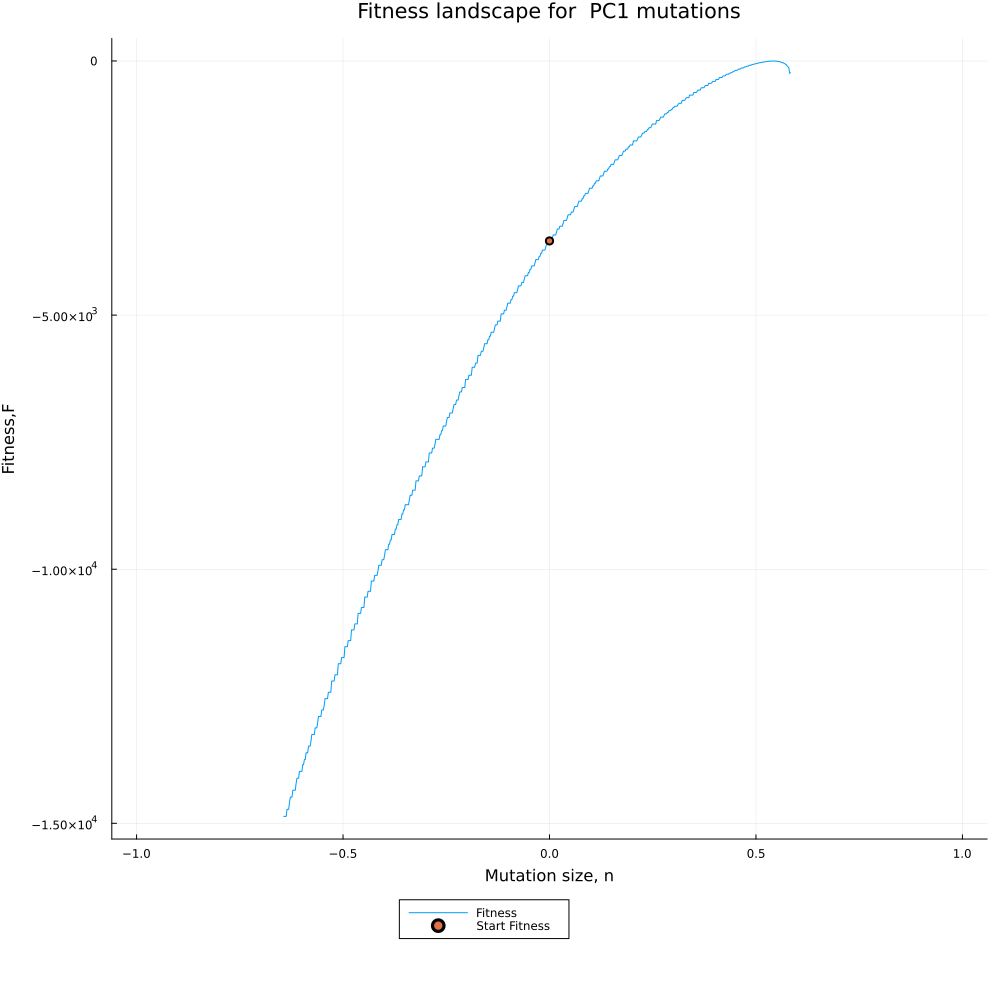

In [222]:
p = plot(sample_steps,all_fitnesses,ylabel = "Fitness,F",xlabel = "Mutation size, n",label = "Fitness",title = "Fitness landscape for  PC1 mutations",legend = :outerbottom,size = (1000,1000))
scatter!(p,(0.,-current_fitness[2]), label = "Start Fitness")

In [229]:
using Plots